In [1]:
import os
import numpy as np
import torch.nn as nn

import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler,Subset
from torchvision import transforms
import torchvision.transforms.functional as TF
from skimage import io
import json
import matplotlib.pyplot as plt
import time
import torch.nn.functional as functional
import glob
import cv2
import random
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pickle

if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
    
torch.cuda.empty_cache()
torch.manual_seed(10)

def cropify(img,pix):
    h,w = img.shape
    n_hrows = int(np.floor(h/pix))
    n_wcols = int(np.floor(w/pix))

    test = np.zeros((h,w))

    for i in range(n_hrows):
        for j in range(n_wcols):
            test[i*pix:i*pix+pix,j*pix:j*pix+pix] = img[i*pix:i*pix+pix,j*pix:j*pix+pix]
    for i in range(n_hrows):
        test[i*pix:i*pix+pix,-pix:] = img[i*pix:i*pix+pix,-pix:]
    for j in range(n_wcols):
        test[-pix:,j*pix:j*pix+pix] = img[-pix:,j*pix:j*pix+pix] 

def imageJ_autocontrast(img):
    out = np.zeros_like(img)
    pixelCount = img.size
    limit = pixelCount/10
    histogram = cv2.calcHist([img],[0],None,[256],[0,256])
    autoThreshold = 5000
    threshold = pixelCount/autoThreshold
    i = -1;
    found = False
    while(not found & (i<255)):
        i+=1
        count = histogram[i]
        if count>limit:
            count=0
        found = count>threshold
    hmin = i
    i = 256
    found = False
    while (not found & (i>0)):
        i-=1
        count = histogram[i]
        if count>limit:
            count=0
        found = count>threshold
    hmax = i
    if (hmax>=hmin):
        new_min = hmin
        new_max = hmax
        if (new_min==new_max):
            new_min=np.min(img)
            new_max=np.max(img)
    else:
        new_min = 0
        new_max = 255
        
    for i in range(img.shape[0]):
        for j in range(img.shape[1]): 
            if 255*(img[i][j]-new_min)/(new_max-new_min) >255:
                out[i][j]=255
            elif 255*(img[i][j]-new_min)/(new_max-new_min) < 0:
                out[i][j]=0
            else:
                out[i][j] = 255*(img[i][j]-new_min)/(new_max-new_min)
#     out = ndimage.median_filter(out,3)
    return out

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

import timeit

Running on the GPU


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, file_list,image_transforms=None,test_transforms=None,phase_flag = 'train'):
        self.img_transform = image_transforms
        self.tst_transform = test_transforms
        self.flag = phase_flag
        self.data_dir = input_dir
        self.files = file_list
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = 'average.*'
        mask_name = '*binary*'
        filename = self.files[idx]
        img = io.imread(glob.glob(os.path.join(self.data_dir, filename, img_name))[0],as_gray=True)        
        mask = io.imread(glob.glob(os.path.join(self.data_dir, filename, mask_name))[0],as_gray=True)

        if mask.dtype == 'float64':
            mask = mask.astype('uint8')
#         clahe = cv2.createCLAHE(clipLimit = 1,tileGridSize=(32,32)) 
#         img = clahe.apply(img)
        img = imageJ_autocontrast(img)
        test = np.zeros(mask.shape)
        test[mask>125] = 1
        mask = test.copy()
        
        # Transform image and mask
        if self.img_transform and self.flag !='test':
            img, mask = self.image_transform(img,mask)
        if self.test_transform and self.flag =='test':
             img, mask = self.test_transform(img,mask)
        
    
        
        # Use dictionary to output
        sample = {'img': img, 'mask': mask, 'filename':filename}
        
        return sample
    
    def image_transform(self,image,mask):
        seed = np.random.randint(100000)
        torch.manual_seed(seed)
        img = self.img_transform(image)
        torch.manual_seed(seed)
        mask = self.img_transform(mask)
        
        return img, mask

    def test_transform(self,image,mask):
        seed = np.random.randint(100000)
        torch.manual_seed(seed)
        img = self.tst_transform(image)
        torch.manual_seed(seed)
        mask = self.tst_transform(mask)
        
        return img, mask



In [3]:
loadtype = 'all'
input_dir = './processed_'+loadtype

img_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.3, 0.1), scale=[1, 2]),
                transforms.RandomCrop(size=(64)),
#                 transforms.ToTensor(),
            ])

dataset = SegmentationDataset(input_dir,img_transform,'train')

dataloader = DataLoader(dataset, batch_size=4, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

TypeError: object of type 'Compose' has no len()

In [4]:
loadtypes = ['gcl','opl','ipl']
version_num = 2
img_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.3, 0.1), scale=[1, 2]),
                transforms.RandomCrop(size=(64, 64)),
            ])

test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomCrop(size=(64, 64)),
            ])
train_data_all = []
val_data_all = []
test_data_all = []
batch_size = 16
if not os.path.exists('./dataloaders/transform_'+str(version_num)):
    for loadtype in loadtypes:
        input_dir = './processed_'+loadtype

        
        validation_split = .2
        test_split = .2
        shuffle_dataset = True

        # Creating data indices for training and validation splits:
        dataset = SegmentationDataset(input_dir,img_transform)
        test_dataset = SegmentationDataset(input_dir,test_transform)
        dataset_size = len(dataset)
        print(dataset_size)

        indices = list(range(dataset_size))
        test_split_idx = int(np.floor(test_split * dataset_size))
        val_split_idx = int(np.floor(validation_split * dataset_size)) + test_split_idx

        if shuffle_dataset :
            np.random.seed(10)
            np.random.shuffle(indices)
        train_indices, val_indices,test_indices = indices[val_split_idx:], indices[test_split_idx:val_split_idx], indices[:test_split_idx]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        ### Save subset
        train_set_iter = Subset(dataset,train_indices)
        train_data_all.append(train_set_iter)
        val_set_iter = Subset(test_dataset,val_indices)
        val_data_all.append(val_set_iter)
        test_set_iter = Subset(test_dataset,test_indices)
        test_data_all.append(test_set_iter)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                   sampler=train_sampler)
        validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                        sampler=valid_sampler,shuffle=False)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                        sampler=test_sampler,shuffle=False)
        with open('./dataloaders/train_'+loadtype+'_'+str(version_num), 'wb') as f:
            pickle.dump(train_set_iter, f)
        with open('./dataloaders/val_'+loadtype+'_'+str(version_num), 'wb') as f:
            pickle.dump(val_set_iter, f)
        with open('./dataloaders/test_'+loadtype+'_'+str(version_num), 'wb') as f:
            pickle.dump(test_set_iter, f)

    with open('./dataloaders/transform_'+str(version_num), 'wb') as f:
        pickle.dump(test_loader, f)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(datasets=train_data_all), batch_size=batch_size)
    validation_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(datasets=val_data_all), batch_size=batch_size,shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(datasets=test_data_all), batch_size=batch_size,shuffle=False)
    with open('./dataloaders/train_all'+'_'+str(version_num), 'wb') as f:
        pickle.dump(train_data_all, f)
    with open('./dataloaders/val_all'+'_'+str(version_num), 'wb') as f:
        pickle.dump(val_data_all, f)
    with open('./dataloaders/test_all'+'_'+str(version_num), 'wb') as f:
        pickle.dump(test_data_all, f)
        
else:
    print('already exists!')

already exists!


In [5]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
    if useBN:
    # Use batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    else:
    # No batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

# Upsampling
def upsample(ch_coarse, ch_fine):
    return nn.Sequential(
        nn.ConvTranspose2d(ch_coarse, ch_fine, 3, 2, 1, output_padding=1,bias=True),
        nn.ReLU()
        )


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            if m.weight is not None:
                torch.nn.init.kaiming_uniform_(m.weight.data)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.01)

# U-Net
class unet(nn.Module):
    def __init__(self, useBN=False,out_channels=2):
        super(unet, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(1, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        # Upgrade stages
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.weight is not None:
                    torch.nn.init.kaiming_uniform_(m.weight.data)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias.data, 0.01)

        self.lastlayer = nn.Sequential(
            nn.Conv2d(32, out_channels, 1, ),
        )
        return  

    def forward(self, x):
       
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))

        conv3m_out_ = torch.cat((self.upsample32(conv3_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)
        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        conv_lastlayer_out = self.lastlayer(conv1m_out)
        return conv_lastlayer_out

def dice_coef(y_hat, y, smooth = 1):
    loss = 0
    length = list(y_hat.size())[0]

    y_f = y.flatten()
    y_hat_f = y_hat.flatten()
    intersection = (y_f * y_hat_f).sum()
    loss = 1 - (2. * intersection + smooth) / (y_f.sum() + y_hat_f.sum() + smooth)
    return loss 
    
def average_dice_coef(y_true, y_pred, numLabels=1):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,index,:,:], y_pred[:,index,:,:])
    return dice/numLabels
    
class DICELoss(nn.Module):
    def forward(self, y_hat, y):
        y_hat = nn.Sigmoid()(y_hat)
        return average_dice_coef(y_hat, y)
    
class FocalLoss2d(nn.Module):
    """Focal Loss.
    Reduces loss for well-classified samples putting focus on hard mis-classified samples.
    See: https://arxiv.org/abs/1708.02002
    """

    def __init__(self, gamma=2, weight=None):
        """Creates a `FocalLoss2d` instance.
        Args:
          gamma: the focusing parameter; if zero this loss is equivalent with `CrossEntropyLoss2d`.
          weight: rescaling weight for each class.
        """

        super().__init__()
        self.nll_loss = nn.NLLLoss(weight)
        self.gamma = gamma

    def forward(self, inputs, targets):
        penalty = (1 - nn.functional.softmax(inputs, dim=1)) ** self.gamma
        return self.nll_loss(penalty * nn.functional.log_softmax(inputs, dim=1), targets)
    
def get_data(version_num=0,loadtype = 'all'):
    
    filename = './dataloaders/train_'+loadtype+'_'+str(version_num)
    file = open(filename, 'rb')
    train = pickle.load(file)
    file.close()
    
    filename = './dataloaders/val_'+loadtype+'_'+str(version_num)
    file = open(filename, 'rb')
    val = pickle.load(file)
    file.close()
    
    filename = './dataloaders/test_'+loadtype+'_'+str(version_num)
    file = open(filename, 'rb')
    test = pickle.load(file)
    file.close()

    return train,val,test

In [6]:
model = unet(useBN=True)
model.to(device)
batch_size=1
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=33)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1]),reduction='none').cuda()


runname = 'testing'
loadtype = 'all'
version_num = 2
train_data,val_data,test_data = get_data(version_num,loadtype)
if loadtype == 'all':
    train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(datasets=train_data), batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(datasets=val_data), batch_size=batch_size,shuffle=False)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(datasets=test_data), batch_size=batch_size,shuffle=False)
else:
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)
    


In [7]:
train_folder_list = []
val_folder_list = []
test_folder_list= []
for idx, sample in enumerate(train_loader):
    train_folder_list.append(sample['filename'][0])

val_folder_list = []
for idx, sample in enumerate(val_loader):
    val_folder_list.append(sample['filename'][0])

test_folder_list = []
for idx, sample in enumerate(test_loader):
    test_folder_list.append(sample['filename'][0])
    
print(len(train_folder_list),len(val_folder_list),len(test_folder_list))



C:\Users\Chris\anaconda3\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


109 34 34


In [8]:
img_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAffine(degrees=0, translate=(0.3, 0.1), scale=[1, 2]),
                transforms.RandomCrop(size=(64)),

            ])

test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomCrop(size=(64)),

            ])
input_dir = './processed_all'
train_data = SegmentationDataset(input_dir=input_dir, file_list=train_folder_list,image_transforms=img_transform,test_transforms=test_transform,phase_flag = 'train') 
val_data = SegmentationDataset(input_dir,val_folder_list,img_transform,test_transform,phase_flag='test') 
test_data = SegmentationDataset(input_dir,test_folder_list,img_transform,test_transform,phase_flag='test')

train_loader = torch.utils.data.DataLoader(train_data,batch_size=1)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=1)
test_loader =torch.utils.data.DataLoader(test_data,batch_size=1)

Epoch 0 / 600
epoch: 0, training loss: 0.3753904296990928, validation loss:0.30439534082132225
Elapsed time for epoch: 26.94519805908203 s
ETA of completion: 269.0028939565023 minutes

new best validation loss
Epoch 1 / 600
epoch: 1, training loss: 0.2902738164871111, validation loss:0.3186165848199059
Elapsed time for epoch: 27.426280975341797 s
ETA of completion: 273.34860038757324 minutes

Early Stop:1
Epoch 2 / 600
epoch: 2, training loss: 0.29397124209261816, validation loss:0.3316374386058134
Elapsed time for epoch: 26.898189544677734 s
ETA of completion: 267.63698596954345 minutes

Early Stop:2
Epoch 3 / 600
epoch: 3, training loss: 0.2593676134807254, validation loss:0.3234742424067329
Elapsed time for epoch: 26.87218475341797 s
ETA of completion: 266.9303685506185 minutes

Early Stop:3
Epoch 4 / 600
epoch: 4, training loss: 0.27303802844034425, validation loss:0.33803802290383506
Elapsed time for epoch: 27.200242042541504 s
ETA of completion: 269.73573358853656 minutes

Early 

epoch: 35, training loss: 0.26015374809503555, validation loss:0.24344952256583116
Elapsed time for epoch: 26.586135149002075 s
ETA of completion: 249.90967040061952 minutes

Early Stop:7
Epoch 36 / 600
epoch: 36, training loss: 0.2503711081221016, validation loss:0.27274487342904596
Elapsed time for epoch: 26.531625509262085 s
ETA of completion: 248.9550860285759 minutes

Early Stop:8
Epoch 37 / 600
epoch: 37, training loss: 0.2244780004844753, validation loss:0.25813783595667167
Elapsed time for epoch: 26.512621879577637 s
ETA of completion: 248.3348916053772 minutes

Early Stop:9
Epoch 38 / 600
epoch: 38, training loss: 0.23318119866585513, validation loss:0.2395365843001534
Elapsed time for epoch: 28.465462923049927 s
ETA of completion: 266.1520783305168 minutes

Early Stop:10
Epoch 39 / 600
epoch: 39, training loss: 0.23930809602414796, validation loss:0.2647507097572088
Elapsed time for epoch: 27.26725459098816 s
ETA of completion: 254.49437618255615 minutes

Early Stop:11
Epoch 

epoch: 71, training loss: 0.22141972331142207, validation loss:0.21481030478196986
Elapsed time for epoch: 26.55962896347046 s
ETA of completion: 233.72473487854003 minutes

Early Stop:17
Epoch 72 / 600
epoch: 72, training loss: 0.2567443749226561, validation loss:0.2681897482013001
Elapsed time for epoch: 26.517123460769653 s
ETA of completion: 232.90873439709347 minutes

Early Stop:18
Epoch 73 / 600
epoch: 73, training loss: 0.20615511633660816, validation loss:0.23331846373484416
Elapsed time for epoch: 26.523624658584595 s
ETA of completion: 232.5237761735916 minutes

Early Stop:19
Epoch 74 / 600
epoch: 74, training loss: 0.24254298698874788, validation loss:0.2410392250646563
Elapsed time for epoch: 26.846681356430054 s
ETA of completion: 234.90846186876297 minutes

Early Stop:20
Epoch 75 / 600
epoch: 75, training loss: 0.20276498736454807, validation loss:0.24602534972569523
Elapsed time for epoch: 26.830677270889282 s
ETA of completion: 234.3212481657664 minutes

Early Stop:21
E

epoch: 106, training loss: 0.20312882337821733, validation loss:0.2526339544531177
Elapsed time for epoch: 27.037714958190918 s
ETA of completion: 222.15989123980205 minutes

Early Stop:17
Epoch 107 / 600
epoch: 107, training loss: 0.20296792798769583, validation loss:0.20265783544848948
Elapsed time for epoch: 26.9601993560791 s
ETA of completion: 221.07363471984863 minutes

Early Stop:18
Epoch 108 / 600
epoch: 108, training loss: 0.21423720161712498, validation loss:0.20544340395752123
Elapsed time for epoch: 27.3412663936615 s
ETA of completion: 223.7426966547966 minutes

Early Stop:19
Epoch 109 / 600
epoch: 109, training loss: 0.22825233829677652, validation loss:0.21492838037802892
Elapsed time for epoch: 27.991379976272583 s
ETA of completion: 228.5962698062261 minutes

Early Stop:20
Epoch 110 / 600
epoch: 110, training loss: 0.2295187035011589, validation loss:0.21152328464257367
Elapsed time for epoch: 27.498794555664062 s
ETA of completion: 224.11517562866212 minutes

Early St

epoch: 141, training loss: 0.19858296543633172, validation loss:0.2068104871055659
Elapsed time for epoch: 27.58030867576599 s
ETA of completion: 210.52968955834706 minutes

Early Stop:11
Epoch 142 / 600
epoch: 142, training loss: 0.19444757739269952, validation loss:0.20578086288536296
Elapsed time for epoch: 27.349267959594727 s
ETA of completion: 208.31025762557982 minutes

Early Stop:12
Epoch 143 / 600
epoch: 143, training loss: 0.20023162488680368, validation loss:0.2568145530188785
Elapsed time for epoch: 28.47746515274048 s
ETA of completion: 216.42873516082764 minutes

Early Stop:13
Epoch 144 / 600
epoch: 144, training loss: 0.1949547905509078, validation loss:0.2371925161603619
Elapsed time for epoch: 27.328263759613037 s
ETA of completion: 207.23933351039886 minutes

Early Stop:14
Epoch 145 / 600
epoch: 145, training loss: 0.2178198280616091, validation loss:0.21650060551131473
Elapsed time for epoch: 27.189239978790283 s
ETA of completion: 205.73191583951314 minutes

Early S

epoch: 176, training loss: 0.19495367333976502, validation loss:0.20204137046547496
Elapsed time for epoch: 27.288757801055908 s
ETA of completion: 192.38574249744414 minutes

Early Stop:19
Epoch 177 / 600
epoch: 177, training loss: 0.2191832430421486, validation loss:0.2165735951241325
Elapsed time for epoch: 27.342267513275146 s
ETA of completion: 192.3072815100352 minutes

Early Stop:20
Epoch 178 / 600
epoch: 178, training loss: 0.21446749318493616, validation loss:0.2000234106226879
Elapsed time for epoch: 27.004708528518677 s
ETA of completion: 189.48303817510606 minutes

Early Stop:21
Epoch 179 / 600
epoch: 179, training loss: 0.2001798395409223, validation loss:0.21686421395005548
Elapsed time for epoch: 26.840678930282593 s
ETA of completion: 187.88475251197815 minutes

Early Stop:22
Epoch 180 / 600
epoch: 180, training loss: 0.19837566786402955, validation loss:0.23117178503204794
Elapsed time for epoch: 26.963701009750366 s
ETA of completion: 188.29651205142338 minutes

Early

epoch: 211, training loss: 0.2035676232035007, validation loss:0.23287095764980598
Elapsed time for epoch: 27.008208990097046 s
ETA of completion: 174.65308480262757 minutes

Early Stop:29
Epoch 212 / 600
epoch: 212, training loss: 0.2172029192875558, validation loss:0.19670775004059954
Elapsed time for epoch: 26.91219139099121 s
ETA of completion: 173.5836344718933 minutes

Early Stop:30
Epoch 213 / 600
epoch: 213, training loss: 0.1989120686546378, validation loss:0.20210032800541206
Elapsed time for epoch: 26.760165691375732 s
ETA of completion: 172.15706594785055 minutes

Early Stop:31
Epoch 214 / 600
epoch: 214, training loss: 0.21566966281981642, validation loss:0.2003436273730853
Elapsed time for epoch: 26.791170120239258 s
ETA of completion: 171.91000827153525 minutes

Early Stop:32
Epoch 215 / 600
epoch: 215, training loss: 0.2107166228559586, validation loss:0.23434794990017133
Elapsed time for epoch: 26.86168360710144 s
ETA of completion: 171.9147750854492 minutes

Early Sto

epoch: 246, training loss: 0.20418350829170384, validation loss:0.21627493367037354
Elapsed time for epoch: 26.783170223236084 s
ETA of completion: 157.57431814670562 minutes

Early Stop:64
Epoch 247 / 600
epoch: 247, training loss: 0.23082935068448748, validation loss:0.2326790894217351
Elapsed time for epoch: 26.999707221984863 s
ETA of completion: 158.39828236897787 minutes

Early Stop:65
Epoch 248 / 600
epoch: 248, training loss: 0.22173561706045353, validation loss:0.18128226779620438
Elapsed time for epoch: 26.82867741584778 s
ETA of completion: 156.9477628827095 minutes

Early Stop:66
Epoch 249 / 600
epoch: 249, training loss: 0.18428154949338063, validation loss:0.20162335405235782
Elapsed time for epoch: 26.9917049407959 s
ETA of completion: 157.45161215464273 minutes

Early Stop:67
Epoch 250 / 600
epoch: 250, training loss: 0.2049187543126968, validation loss:0.22899964506573536
Elapsed time for epoch: 26.913692235946655 s
ETA of completion: 156.54797650575637 minutes

Early 

epoch: 281, training loss: 0.19658033864213786, validation loss:0.24773812425487182
Elapsed time for epoch: 26.49311900138855 s
ETA of completion: 140.4135307073593 minutes

Early Stop:99
Epoch 282 / 600
epoch: 282, training loss: 0.2032156848271779, validation loss:0.23564461498137781
Elapsed time for epoch: 26.614140272140503 s
ETA of completion: 140.611374437809 minutes

Early Stop:100
Epoch 283 / 600
epoch: 283, training loss: 0.21282225795978799, validation loss:0.1933708846130792
Elapsed time for epoch: 26.59113645553589 s
ETA of completion: 140.04665199915567 minutes

Early Stop:101
Epoch 284 / 600
epoch: 284, training loss: 0.19685908034443855, validation loss:0.1999687035841977
Elapsed time for epoch: 26.63014268875122 s
ETA of completion: 139.8082491159439 minutes

Early Stop:102
Epoch 285 / 600
epoch: 285, training loss: 0.19367201246936386, validation loss:0.24239936432636836
Elapsed time for epoch: 26.409103870391846 s
ETA of completion: 138.207643588384 minutes

Early Sto

epoch: 316, training loss: 0.19125501606442513, validation loss:0.24512960882309606
Elapsed time for epoch: 26.429607629776 s
ETA of completion: 124.65964932044348 minutes

Early Stop:134
Epoch 317 / 600
epoch: 317, training loss: 0.1904579924265726, validation loss:0.2050806348595549
Elapsed time for epoch: 26.491619110107422 s
ETA of completion: 124.51060981750489 minutes

Early Stop:135
Epoch 318 / 600
epoch: 318, training loss: 0.21874340481782725, validation loss:0.22513199586640387
Elapsed time for epoch: 26.493118047714233 s
ETA of completion: 124.07610285679499 minutes

Early Stop:136
Epoch 319 / 600
epoch: 319, training loss: 0.18533391584086856, validation loss:0.27113646553719745
Elapsed time for epoch: 26.54962944984436 s
ETA of completion: 123.89827076594035 minutes

Early Stop:137
Epoch 320 / 600
epoch: 320, training loss: 0.19477800642131665, validation loss:0.1933547439163222
Elapsed time for epoch: 26.5096218585968 s
ETA of completion: 123.26974164247513 minutes

Early

epoch: 351, training loss: 0.22926183508008446, validation loss:0.21833139704540372
Elapsed time for epoch: 26.539625644683838 s
ETA of completion: 109.69711933135986 minutes

Early Stop:169
Epoch 352 / 600
epoch: 352, training loss: 0.20023554543016153, validation loss:0.2290355197208769
Elapsed time for epoch: 26.549628734588623 s
ETA of completion: 109.29597162405649 minutes

Early Stop:170
Epoch 353 / 600
epoch: 353, training loss: 0.20443777341839917, validation loss:0.2312940409516587
Elapsed time for epoch: 29.002556085586548 s
ETA of completion: 118.91047995090484 minutes

Early Stop:171
Epoch 354 / 600
epoch: 354, training loss: 0.19691431894898415, validation loss:0.24107851405792377
Elapsed time for epoch: 26.496119499206543 s
ETA of completion: 108.19248795509338 minutes

Early Stop:172
Epoch 355 / 600
epoch: 355, training loss: 0.1957431070062272, validation loss:0.19147050062961438
Elapsed time for epoch: 26.516122579574585 s
ETA of completion: 107.83223182360331 minutes


epoch: 386, training loss: 0.2034648409745562, validation loss:0.20239318885347424
Elapsed time for epoch: 26.4561128616333 s
ETA of completion: 93.91920065879822 minutes

Early Stop:204
Epoch 387 / 600
epoch: 387, training loss: 0.20961703223372818, validation loss:0.20924815316410625
Elapsed time for epoch: 26.493619203567505 s
ETA of completion: 93.61078785260518 minutes

Early Stop:205
Epoch 388 / 600
epoch: 388, training loss: 0.19340500813148437, validation loss:0.22725688337403185
Elapsed time for epoch: 26.433608531951904 s
ETA of completion: 92.95819000403087 minutes

Early Stop:206
Epoch 389 / 600
epoch: 389, training loss: 0.21665028800521421, validation loss:0.22406799718737602
Elapsed time for epoch: 26.426607608795166 s
ETA of completion: 92.49312663078308 minutes

Early Stop:207
Epoch 390 / 600
epoch: 390, training loss: 0.2073234885999369, validation loss:0.2694619946620044
Elapsed time for epoch: 26.337591409683228 s
ETA of completion: 91.74261007706325 minutes

Early 

epoch: 421, training loss: 0.19758658189702472, validation loss:0.1791049880797372
Elapsed time for epoch: 26.524123907089233 s
ETA of completion: 78.68823425769806 minutes

Early Stop:239
Epoch 422 / 600
epoch: 422, training loss: 0.19830404543275132, validation loss:0.20970331965123906
Elapsed time for epoch: 26.563130855560303 s
ETA of completion: 78.36123602390289 minutes

Early Stop:240
Epoch 423 / 600
epoch: 423, training loss: 0.1980665333637404, validation loss:0.22847462522194667
Elapsed time for epoch: 26.47411608695984 s
ETA of completion: 77.65740718841553 minutes

Early Stop:241
Epoch 424 / 600
epoch: 424, training loss: 0.2145776072294887, validation loss:0.20786990992286625
Elapsed time for epoch: 26.44611120223999 s
ETA of completion: 77.13449100653331 minutes

Early Stop:242
Epoch 425 / 600
epoch: 425, training loss: 0.20746823335322764, validation loss:0.19490185719640815
Elapsed time for epoch: 26.406104564666748 s
ETA of completion: 76.57770323753357 minutes

Early 

epoch: 456, training loss: 0.19844167829926954, validation loss:0.20751440809930072
Elapsed time for epoch: 26.592137098312378 s
ETA of completion: 63.377926750977835 minutes

Early Stop:274
Epoch 457 / 600
epoch: 457, training loss: 0.20462375378595032, validation loss:0.25225599636049834
Elapsed time for epoch: 26.6101393699646 s
ETA of completion: 62.97732984224955 minutes

Early Stop:275
Epoch 458 / 600
epoch: 458, training loss: 0.21610043900207096, validation loss:0.2170855615507154
Elapsed time for epoch: 26.626142740249634 s
ETA of completion: 62.57143543958664 minutes

Early Stop:276
Epoch 459 / 600
epoch: 459, training loss: 0.19069048926370954, validation loss:0.2153012311524328
Elapsed time for epoch: 26.48761820793152 s
ETA of completion: 61.804442485173546 minutes

Early Stop:277
Epoch 460 / 600
epoch: 460, training loss: 0.19534635909516876, validation loss:0.20519324057899854
Elapsed time for epoch: 26.518122911453247 s
ETA of completion: 61.433651411533354 minutes

Ear

Text(0.5, 1.0, 'Epoch Loss')

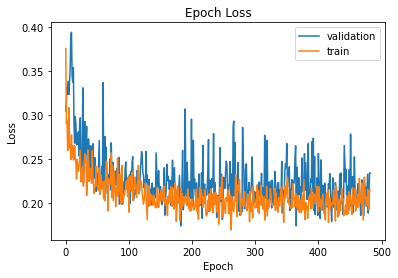

In [55]:
epochs = 600
epoch_loss = []
epoch_val_loss = []
patience = 300
best_val_loss = 1e10
model.apply(weights_init)
for epoch in range(epochs):
    print('='*30)
    print('Epoch {} / {}'.format(epoch, epochs))
    
    # Set variables
    correct = 0
    overlap = 0 
    union = 0
    _len = 0
    l = 0
    val_l = 0
    count = 0
    val_count = 0
    
    # Loop over the batches
    model.train()
    for index, sample in enumerate(train_loader):
        time1 = time.time() #timekeeping


        if device is not None:
            X = sample['img'].to(device)
            Y = sample['mask'].float().to(device)

        # Call the model (image to mask)
        R = model(X.float())
        # Compute the loss
        L = criterion(R.permute(1,0,2,3)[0], Y.squeeze(1)).mean()

        # Do PyTorch stuff
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        l = l + L.data.item()
        
        count +=1
    with torch.no_grad():
        for index, sample in enumerate(val_loader):
            #print(f'\tBatch {index}')
            model.eval()
            
            if device is not None:
                X = sample['img'].to(device)
                Y = sample['mask'].float().to(device)

            # Call the model (image to mask)
            R = model(X.float())
    
            # Compute the loss
            val_L = criterion(R.permute(1,0,2,3)[0],Y.squeeze(1)).mean()
            val_l = val_l + val_L.data.item()
            val_count += 1
            
    val_loss = val_l/val_count
    _loss = l/count

    string = "epoch: {}, training loss: {}, validation loss:{}".format(epoch, _loss, val_loss)
    print(string)
    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()
    if val_loss < best_val_loss:
        print("new best validation loss")
        best_val_loss = val_loss
        earlystopcount = 0
        torch.save(model.state_dict(), './models/last_model_'+str(version_num)+'_'+loadtype+'_5_5FINAL')
    else:
        earlystopcount+=1
        print("Early Stop:{}".format(earlystopcount))
    if earlystopcount > patience:
        break
    epoch_loss.append(_loss)
    epoch_val_loss.append(val_loss)
    scheduler.step(val_loss)
plt.figure()
plt.plot(epoch_val_loss, label='validation')
plt.plot(epoch_loss, label='train')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss')

In [9]:
num_classes = 2

from sklearn.metrics import roc_curve, accuracy_score, auc
def OHC(mask,num_classes):
    h,w = mask.shape
    new_mask = np.zeros((h, w, num_classes))
    for idx in range(num_classes):
        idx_mat = np.ones(mask.shape)*idx
#         print((np.array(idx_mat)==np.array(mask.cpu())).sum())
        new_mask[:, :, idx] = np.array(np.array(idx_mat)==np.array(mask.cpu()))    
    return torch.tensor(new_mask).to(device)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)


def test_eval(dataloader=test_loader):
    dice_score = 0
    count = 0
    with torch.no_grad():
        for idx,sample in enumerate(dataloader):
            images = sample['img']
            labels = sample['mask']
            if device is not None:
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images.float())        
            predicted = torch.argmax(outputs.data, 1)
            for i in range(len(sample['img'])):
                for j in range(num_classes):
                    dice_score += dice_coef(OHC(torch.squeeze(torch.squeeze(labels[i],0),1),num_classes)[:,:,j],OHC(predicted[i],num_classes)[:,:,j])
                    count+=1
    return dice_score/count

def show_samples(dataloader=test_loader):
    print("="*45)
    stopcount = 0
    with torch.no_grad():
        for idx,sample in enumerate(dataloader):
            images = sample['img']
            labels = sample['mask']
            if device is not None:
                images, labels = images.cuda(), labels.cuda()
            
            outputs = model(images.float())
            print(labels.unique())
            
            predicted = torch.round(outputs.data)
            for i in range(len(sample['img'])):
                for j in range(num_classes):
                    stopcount +=1
                    if stopcount >= 0 and stopcount%2 == 0:
                        f, axarr = plt.subplots(nrows=1,ncols=3)
                        print(sample['filename'][i])
                        axarr[0].imshow(sample['img'][i][0],cmap='gray')
                        axarr[1].imshow(torch.squeeze(torch.squeeze(labels[i],0),1).cpu().numpy(),cmap='gray')
                        axarr[2].imshow(predicted[i].cpu().numpy()[0],cmap='gray')
                    
            if stopcount >= 30:
                break
                
def cropify(img,pix):
    h,w = img.shape
    n_hrows = int(np.floor(h/pix))
    n_wcols = int(np.floor(w/pix))

    test = np.zeros((h,w))

    for i in range(n_hrows):
        for j in range(n_wcols):
            crop = img[i*pix:i*pix+pix,j*pix:j*pix+pix]
            crop = transforms.ToTensor()(crop).to(device).unsqueeze(0)
            outputs = nn.Sigmoid()(model(crop.float()))
            predicted = torch.round(outputs.data)
            crop_mask = predicted[0][0].cpu().numpy()
            test[i*pix:i*pix+pix,j*pix:j*pix+pix] += crop_mask
            
    #boundaries
    for i in range(n_hrows):
        for j in range(n_wcols):
            crop = img[i*pix:i*pix+pix,-pix*j-pix:w-pix*j]
            crop = transforms.ToTensor()(crop).to(device).unsqueeze(0)
            outputs = nn.Sigmoid()(model(crop.float()))
            predicted = torch.round(outputs.data)
            crop_mask = predicted[0][0].cpu().numpy()
            test[i*pix:i*pix+pix,-pix*j-pix:w-pix*j] += crop_mask
    for i in range(n_hrows):    
        for j in range(n_wcols):
            crop = img[-pix*i-pix:h-pix*i,j*pix:j*pix+pix]
            crop = transforms.ToTensor()(crop).to(device).unsqueeze(0)
            outputs = nn.Sigmoid()(model(crop.float()))
            predicted = torch.round(outputs.data)
            crop_mask = predicted[0][0].cpu().numpy()
            test[-pix*i-pix:h-pix*i,j*pix:j*pix+pix] += crop_mask
    output = np.zeros((h,w))
    output[test!=0] = 1
    return output

def othermetrics(mask,pred):
    y_true = np.array(mask).flatten()
    y_pred = np.array(pred).flatten()
    precision, recall,_,_ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)
    return precision, recall, acc


def full_image(net_g, image_stack, img_size=64, padding=16,bin_bool=True):
    probability_map = np.zeros((image_stack.shape[1], image_stack.shape[2]), dtype=np.float32)
    probability_map_count = np.zeros((image_stack.shape[1], image_stack.shape[2]), dtype=np.float32)
    count_matrix = np.ones((img_size, img_size), dtype=np.float32)

    for i in range(0, image_stack.shape[2]-img_size, padding):
        for j in range(0, image_stack.shape[1]-img_size, padding):
            img_single = image_stack[:, j:j+img_size, i:i+img_size]#
            out_single = single_patch(net_g, img_single,bin_bool) #
            probability_map[j:j + img_size, i:i + img_size] = probability_map[j:j + img_size,
                                                                i:i + img_size] + out_single
            probability_map_count[j:j + img_size, i:i + img_size] = probability_map_count[j:j + img_size,
                                                                i:i + img_size] + count_matrix


        img_single = image_stack[:, image_stack.shape[1] - img_size:image_stack.shape[1], i:i + img_size] #
        out_single = single_patch(net_g, img_single,bin_bool) #
        probability_map[image_stack.shape[1] - img_size:image_stack.shape[1], i:i + img_size] += out_single
        probability_map_count[image_stack.shape[1] - img_size:image_stack.shape[1], i:i + img_size] += count_matrix

    for j in range(0, image_stack.shape[1]-img_size, padding):
        img_single = image_stack[:, j:j + img_size, image_stack.shape[2] - img_size:image_stack.shape[2]]
        out_single = single_patch(net_g, img_single,bin_bool)
        probability_map[j:j + img_size, image_stack.shape[2] - img_size:image_stack.shape[2]] = probability_map[j:j + img_size, image_stack.shape[2] - img_size:image_stack.shape[2]] + out_single
        probability_map_count[j:j + img_size, image_stack.shape[2] - img_size:image_stack.shape[2]] = probability_map_count[j:j + img_size, image_stack.shape[2] - img_size:image_stack.shape[2]] + count_matrix

    img_single = image_stack[:, image_stack.shape[1] - img_size:image_stack.shape[1], image_stack.shape[2] - img_size:image_stack.shape[2]]
    out_single = single_patch(net_g, img_single,bin_bool)
    probability_map[image_stack.shape[1] - img_size:image_stack.shape[1], image_stack.shape[2] - img_size:image_stack.shape[2]] = probability_map[image_stack.shape[1] - img_size:image_stack.shape[1], image_stack.shape[2] - img_size:image_stack.shape[2]] + out_single
    probability_map_count[image_stack.shape[1] - img_size:image_stack.shape[1], image_stack.shape[2] - img_size:image_stack.shape[2]] = probability_map_count[image_stack.shape[1] - img_size:image_stack.shape[1], image_stack.shape[2] - img_size:image_stack.shape[2]] + count_matrix

    final_result = np.divide(probability_map, probability_map_count+0.000001)
    return final_result

def single_patch(net_g, img_single,bin_bool=True):
    input_single = img_single.unsqueeze(0)
    out_single = net_g(input_single)
    out_single = nn.Sigmoid()(out_single)
    out_single = torch.round(out_single.data)

    if len(out_single.shape)>2:
        out_single = out_single[0][0]
    out_single = out_single.cpu().float().numpy()
    return out_single

def get_auc(mask,pred):
    if np.max(mask)>1:
        mask = mask/255
    if np.max(pred)>1:
        pred= pred/255
    if len(np.unique(mask))>2:
        mask = mask>0.5
    y_true = np.array(mask).flatten()
    y_pred = np.array(pred).flatten()
    fpr,tpr,thresh = roc_curve(y_true,y_pred)
    
    auc_score = auc(fpr,tpr)
    opt_thresh = int(255*thresh[np.argmin((1 - tpr) ** 2 + fpr ** 2)])
    return auc_score,opt_thresh

The start time is : 23533.6327045
The time difference is : 0.0005151000004843809
The time difference is : 1.5626587000006111


<ipython-input-14-8f863a277daf>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1,4,figsize=(20,10))


dice: 0.6450217105061604
prec: 0.6285549661688244
recall: 0.702659077514978
accuracy: 0.913760207877855
AUC: 0.8300358772793613


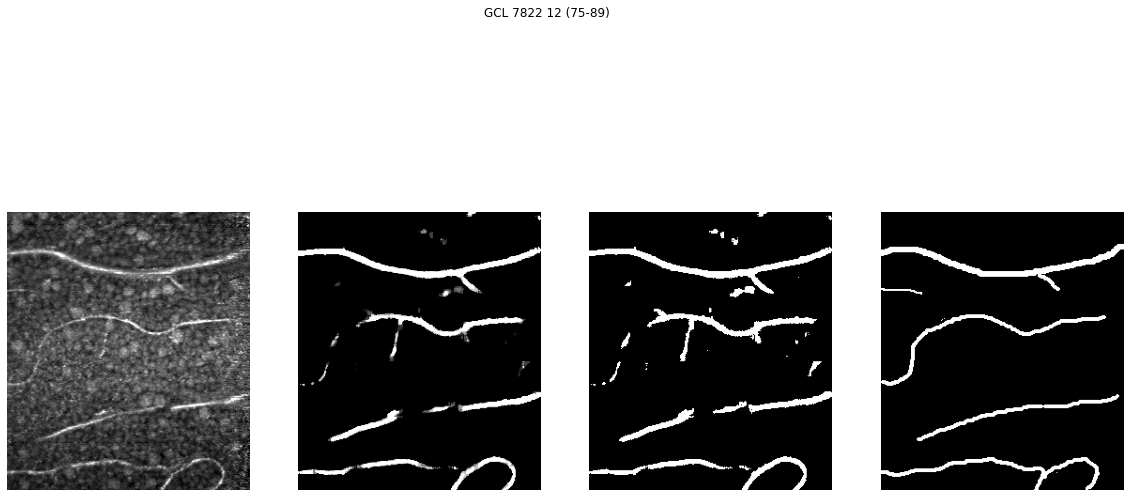

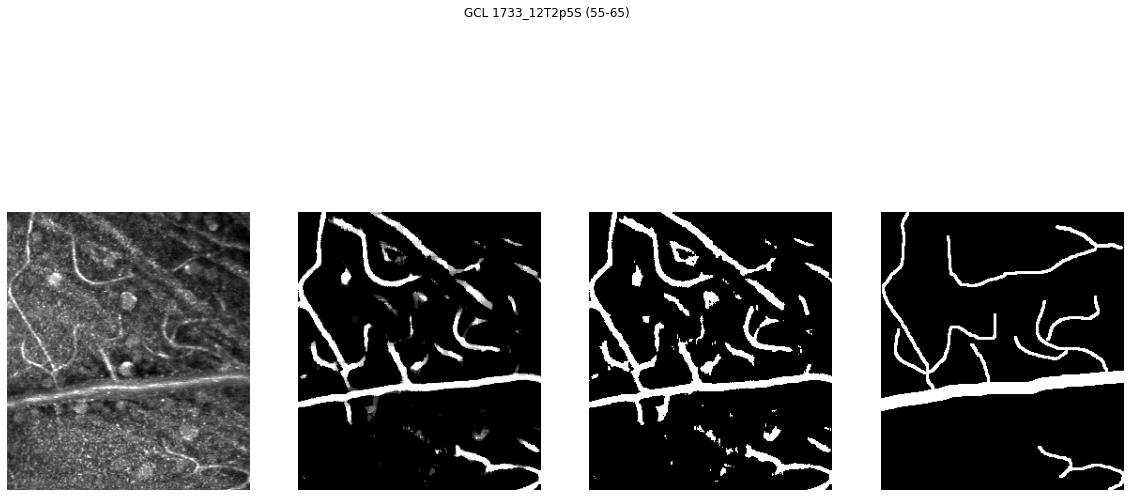

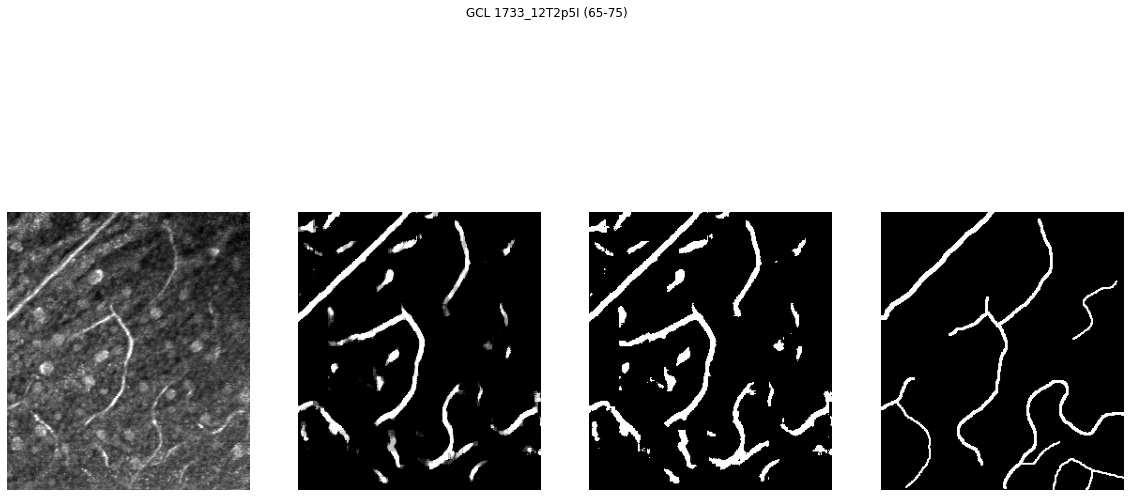

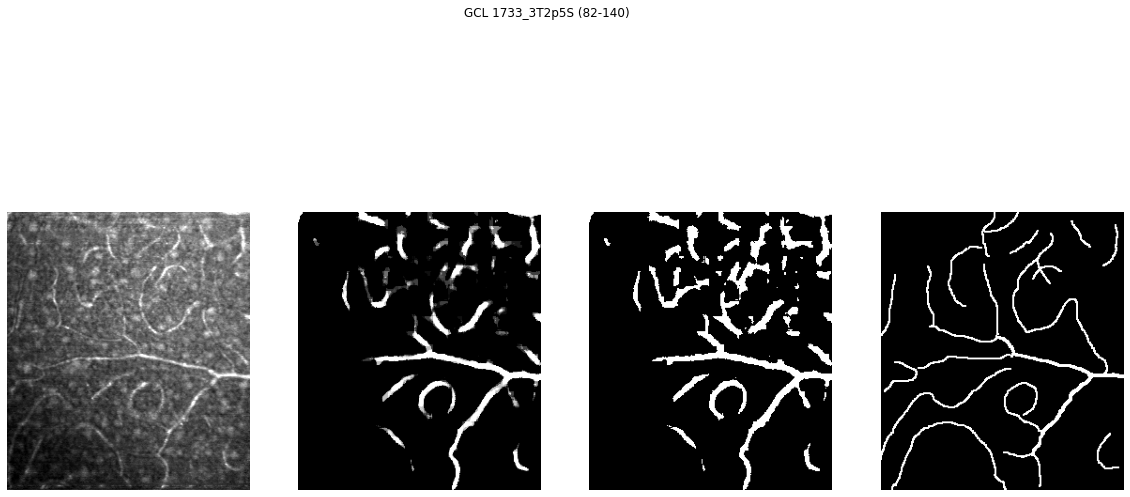

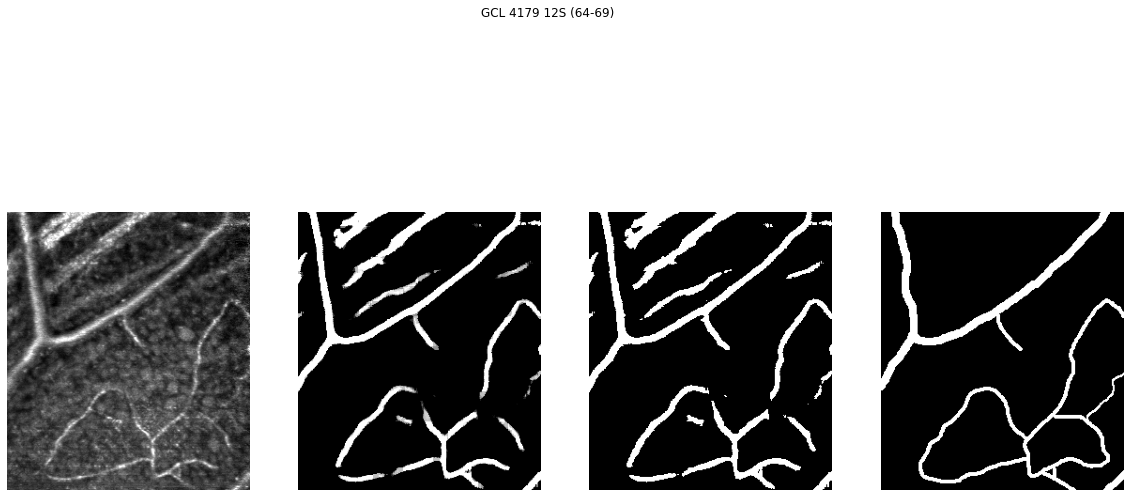

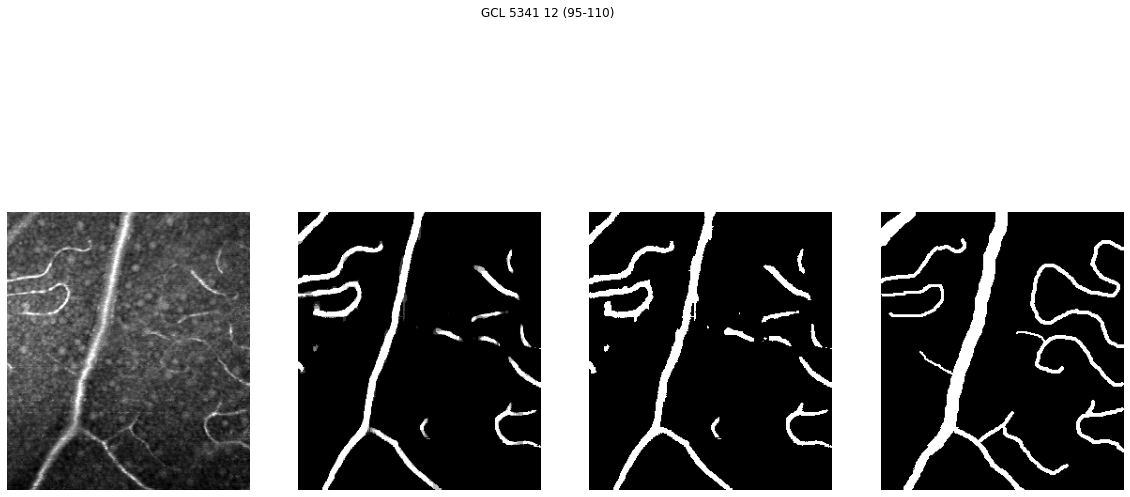

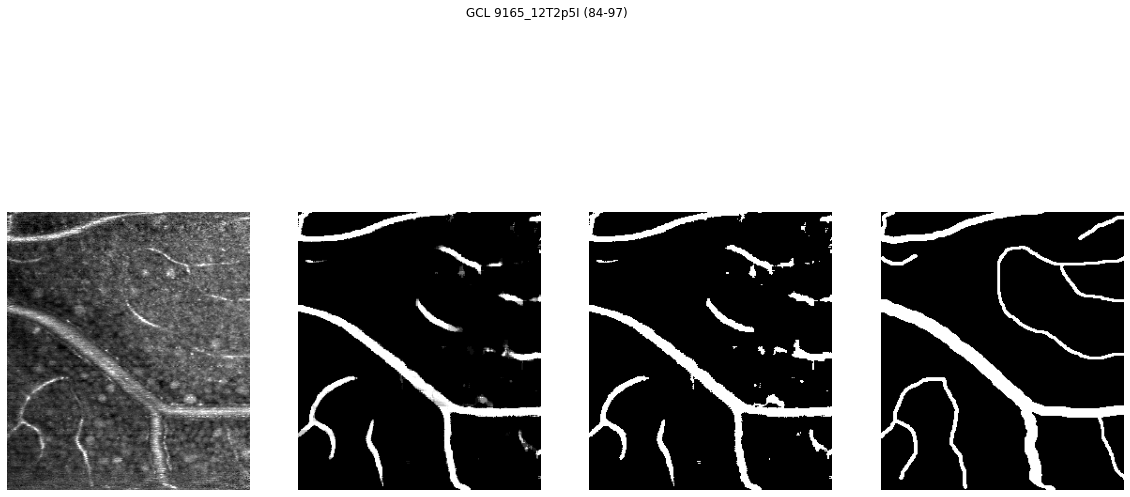

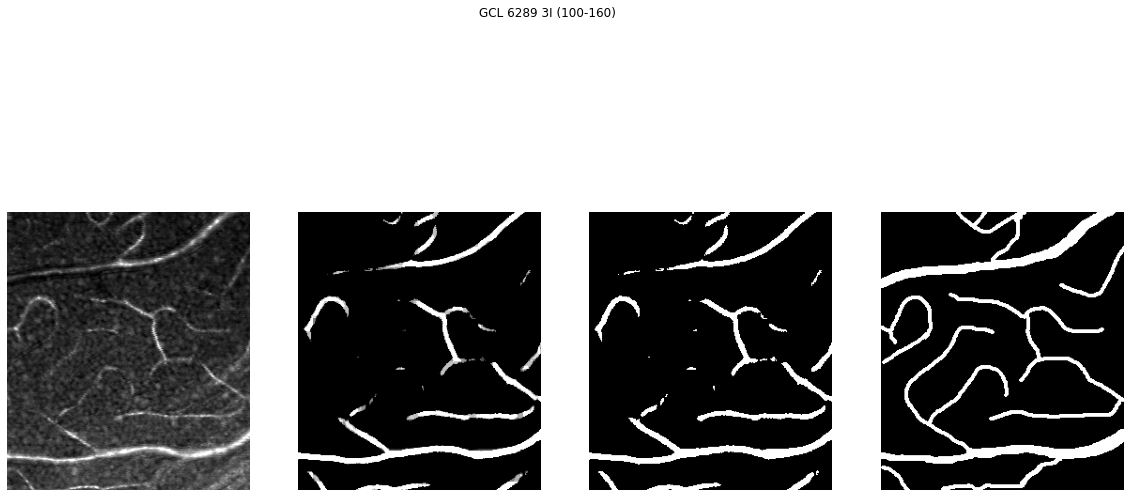

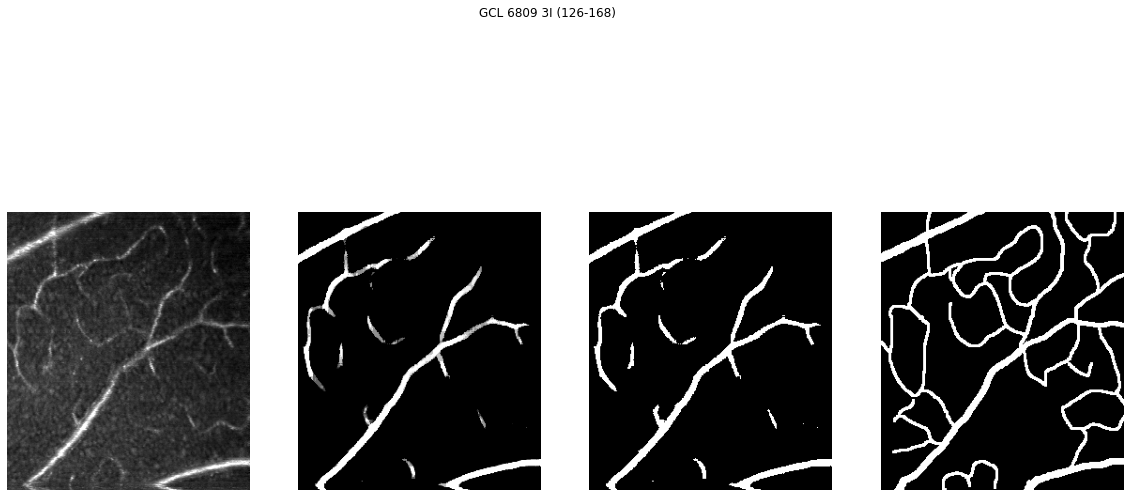

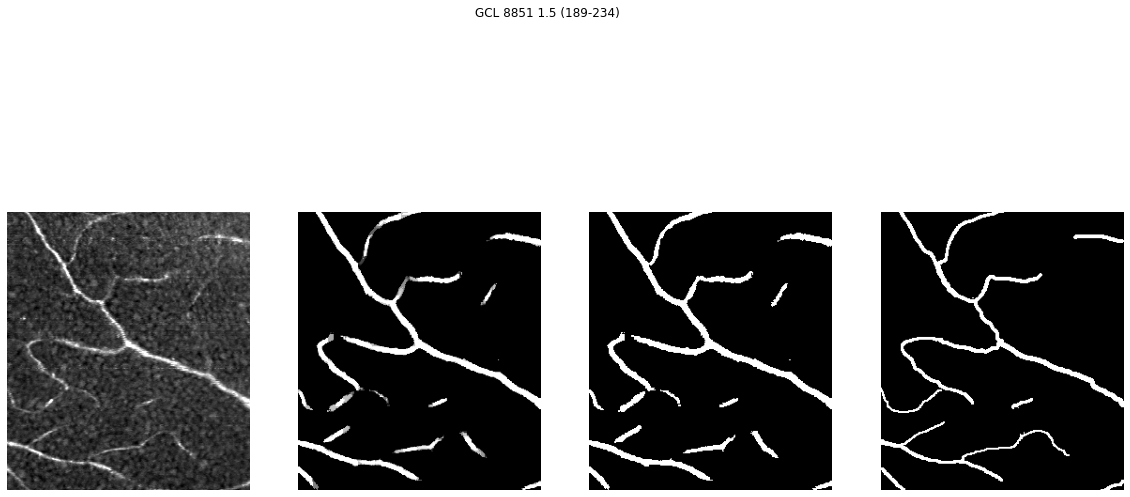

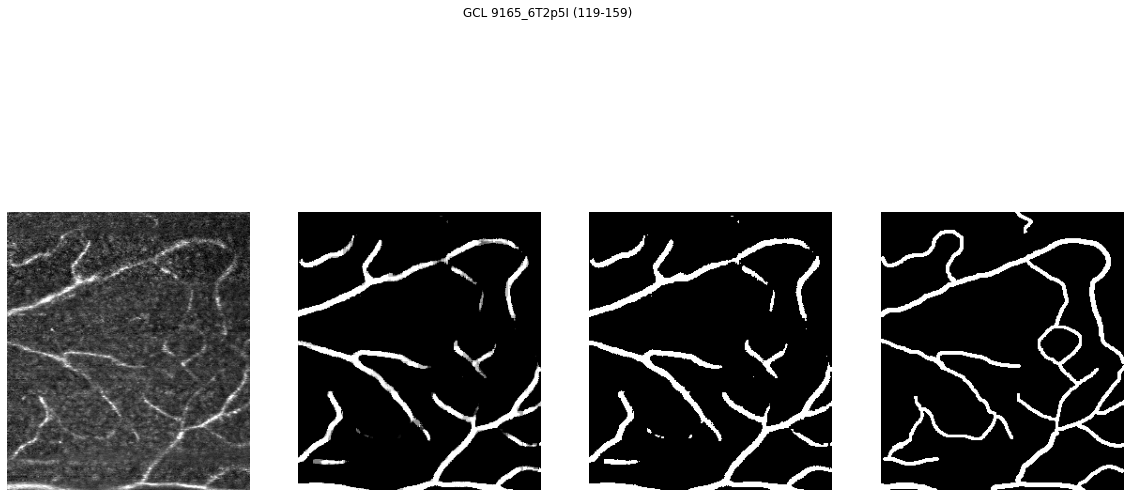

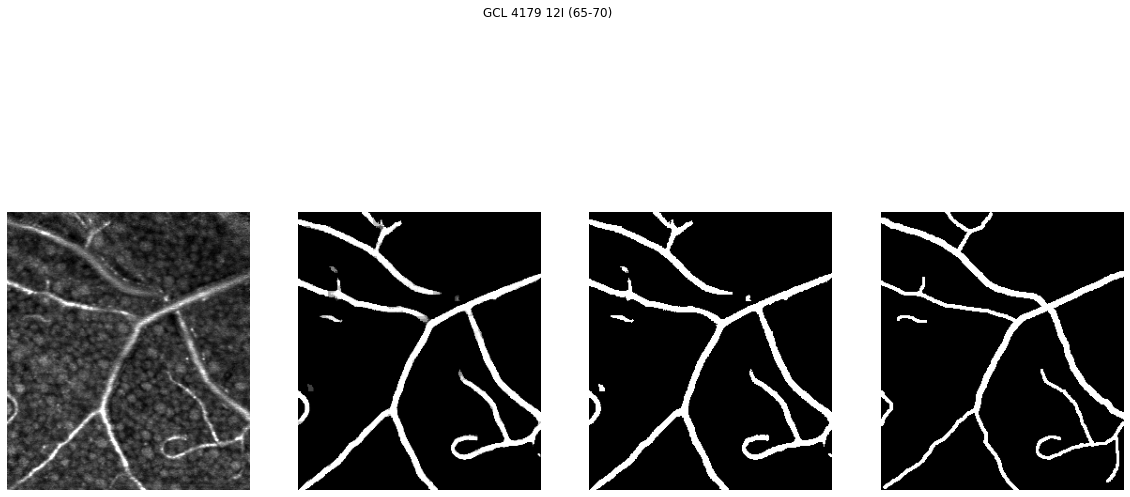

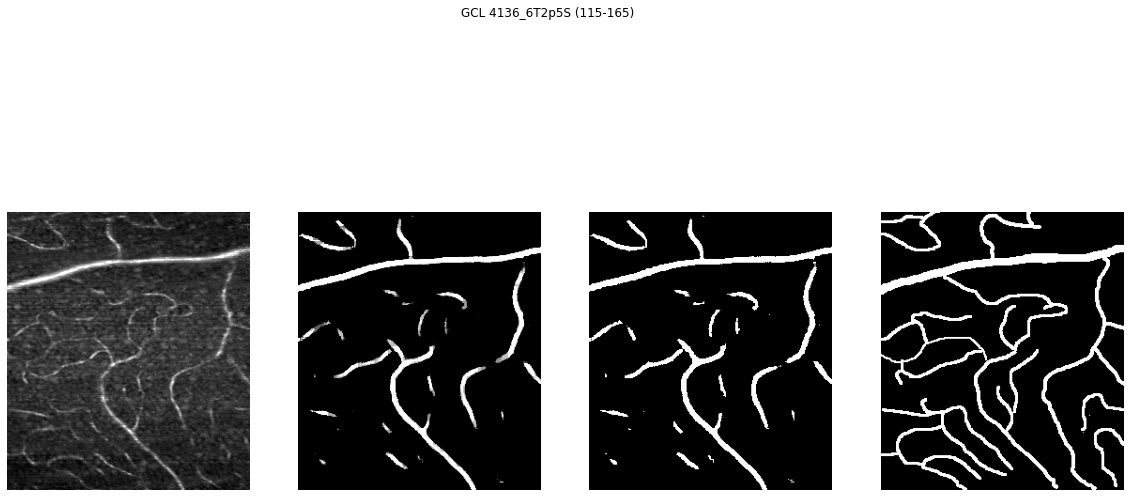

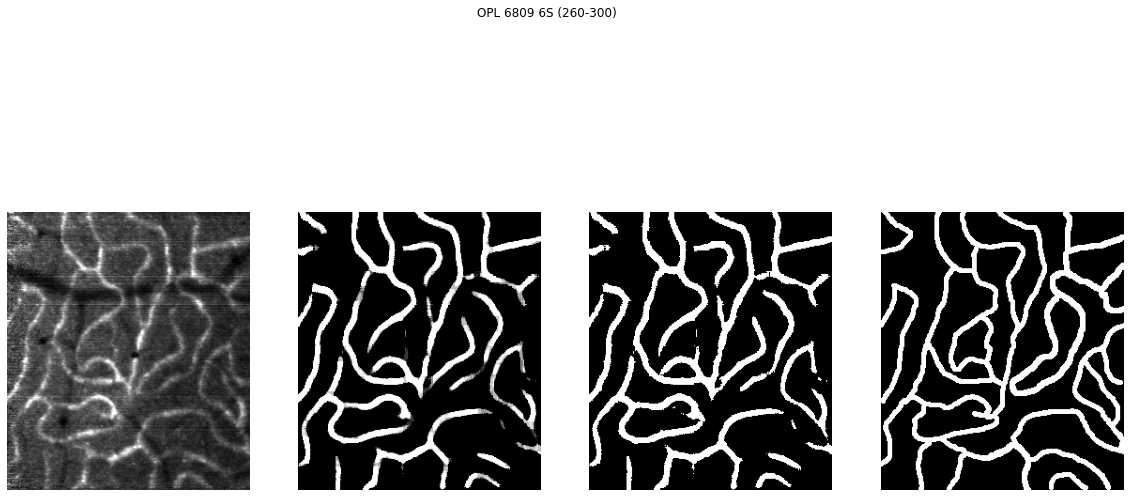

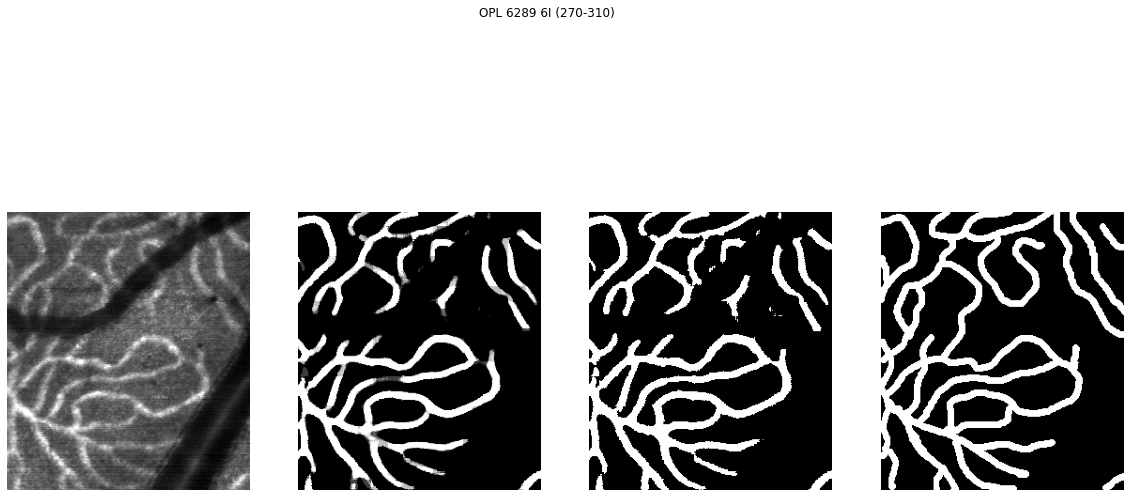

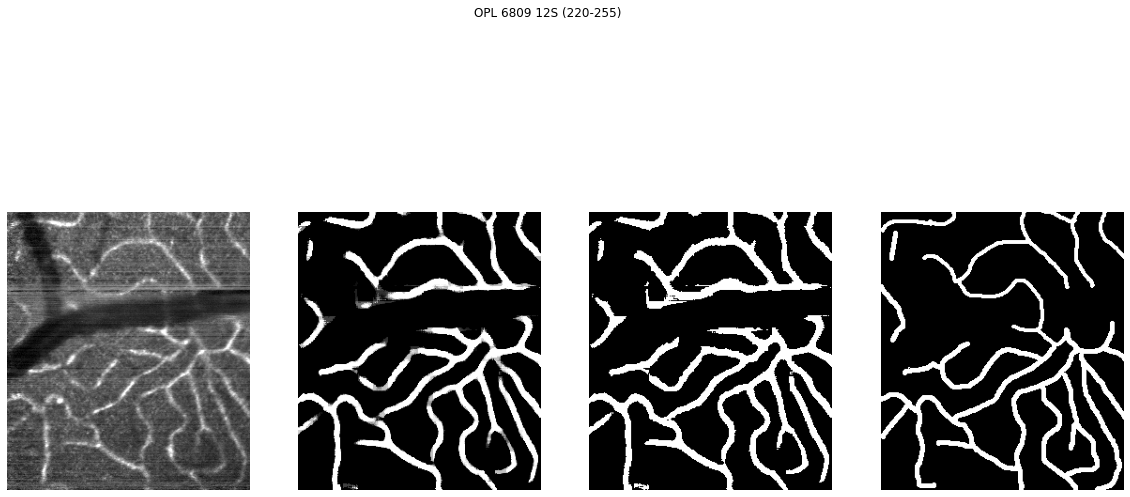

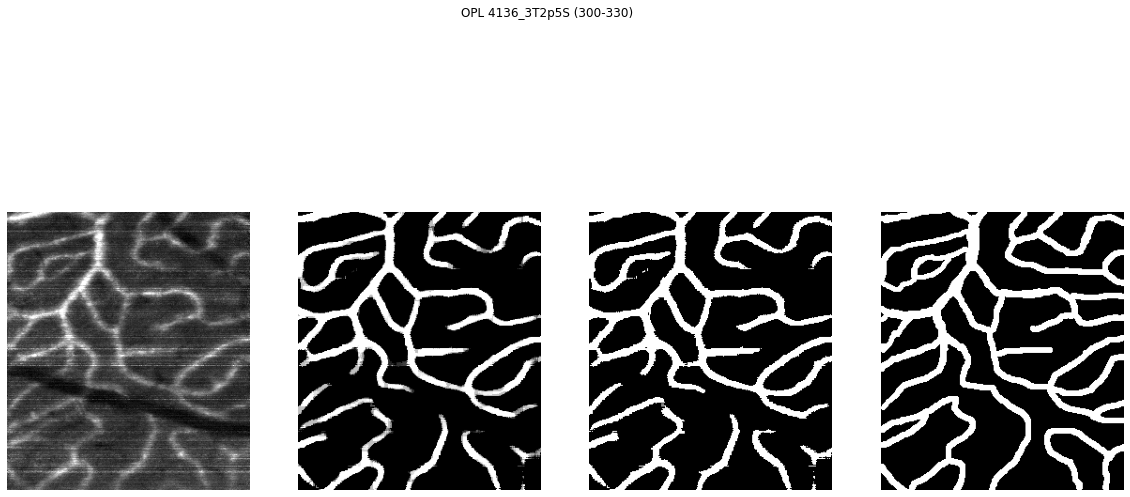

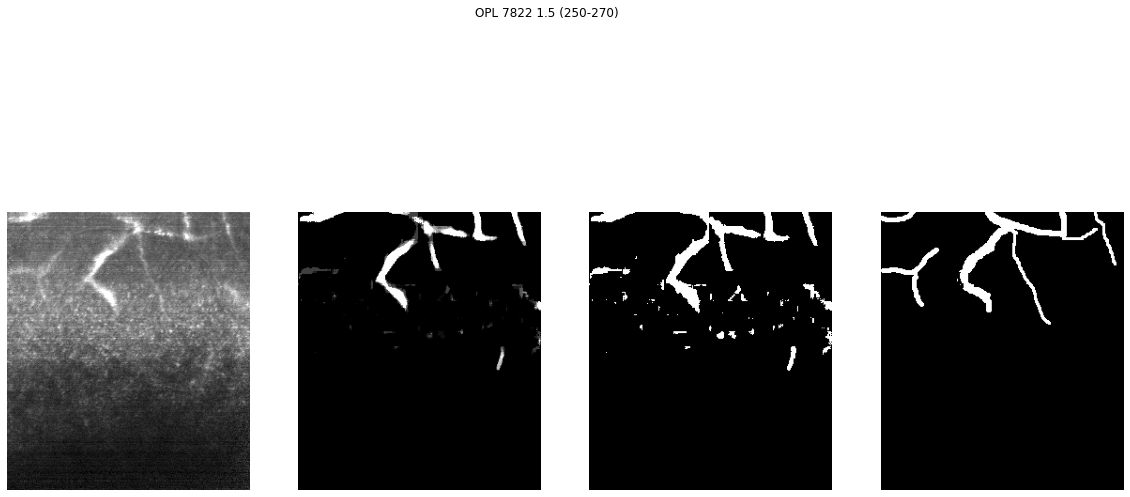

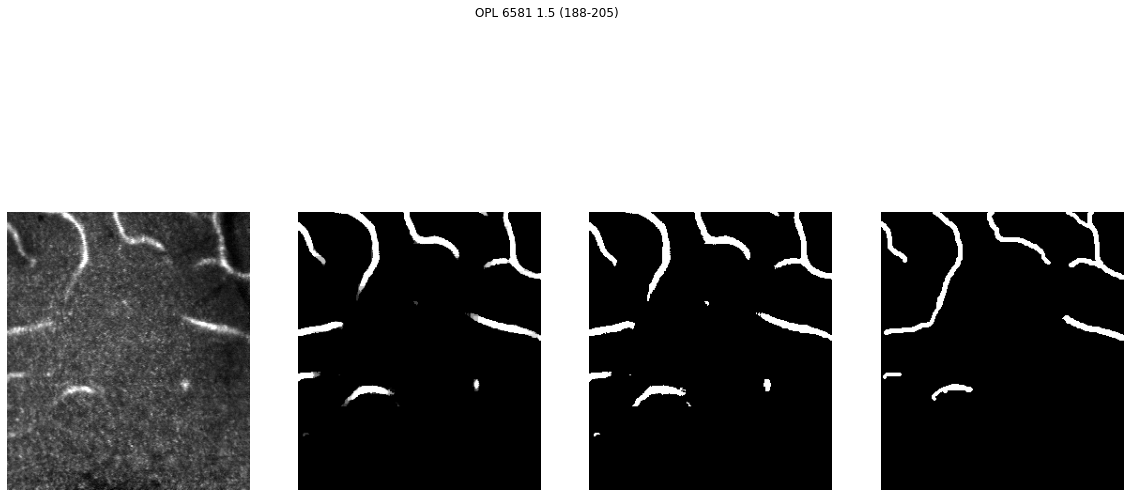

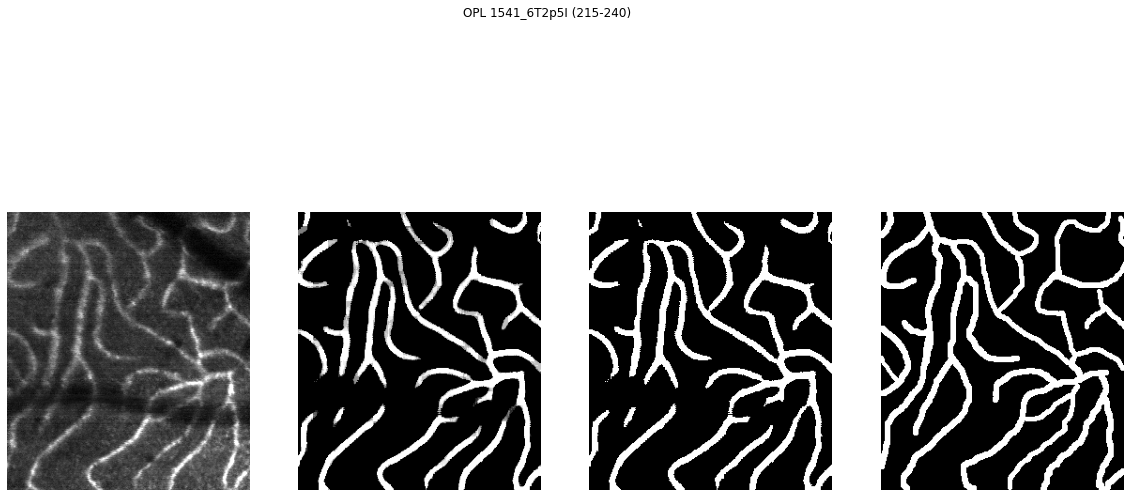

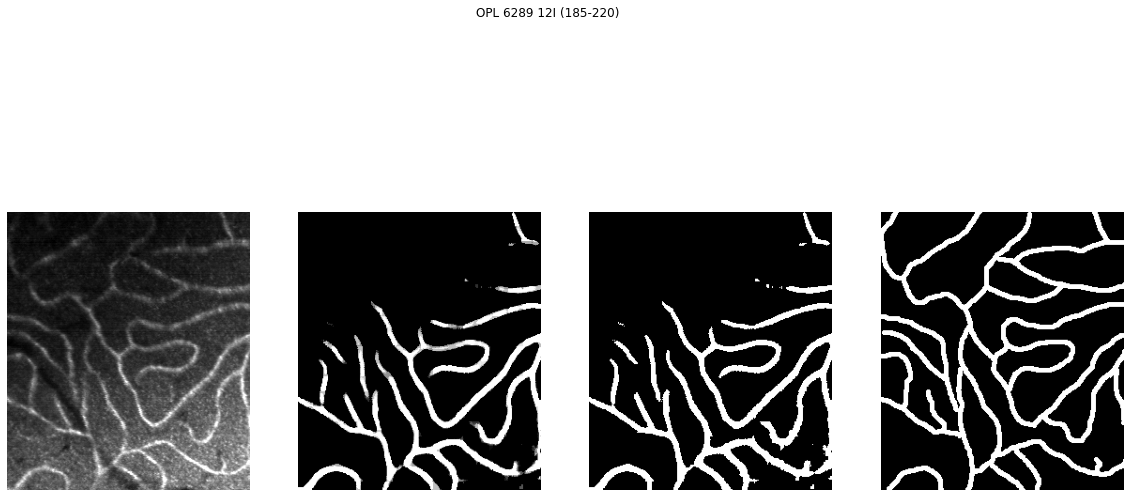

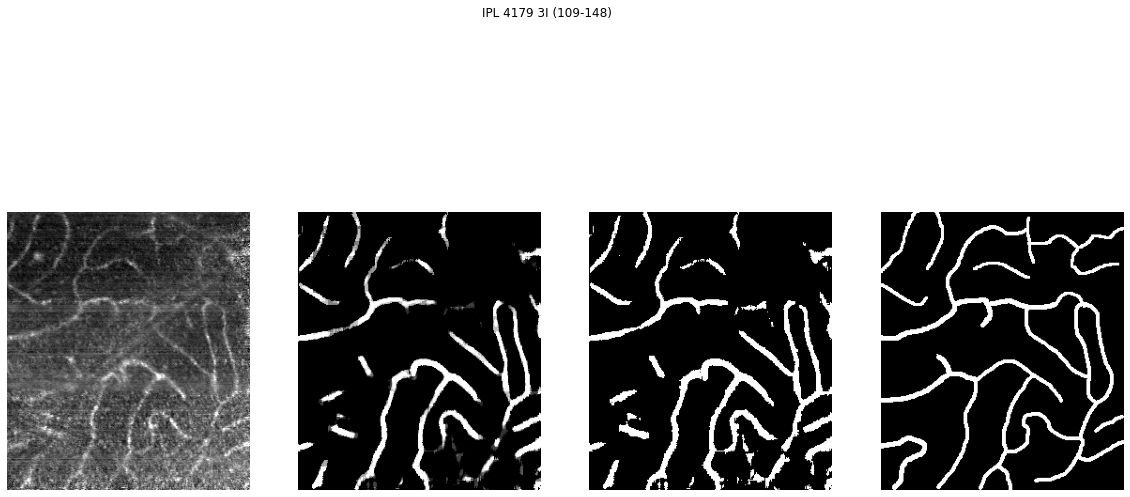

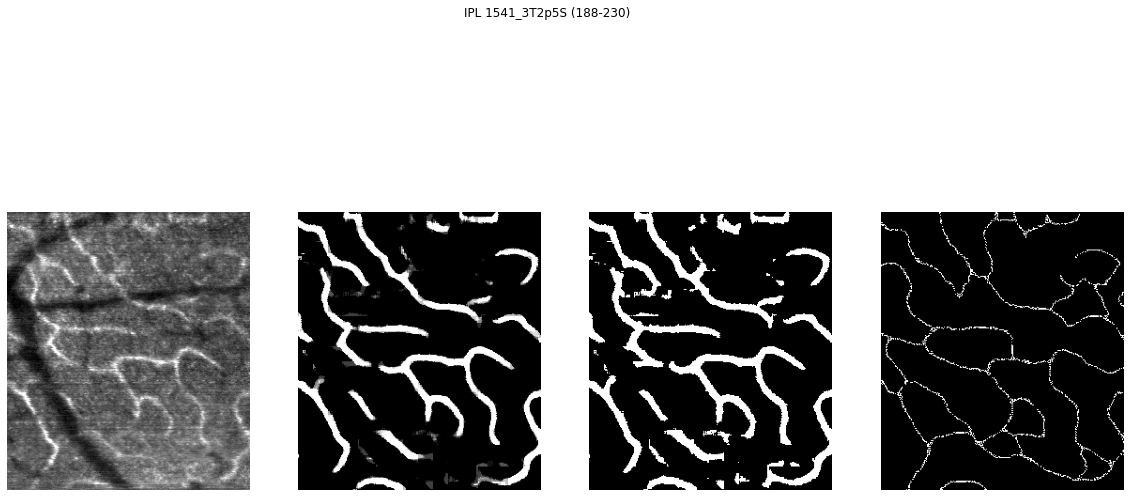

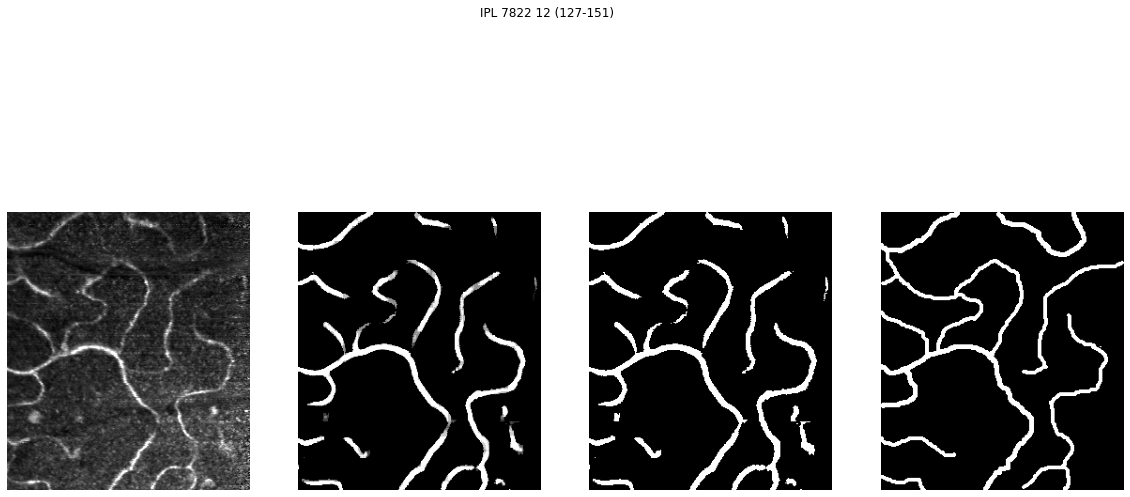

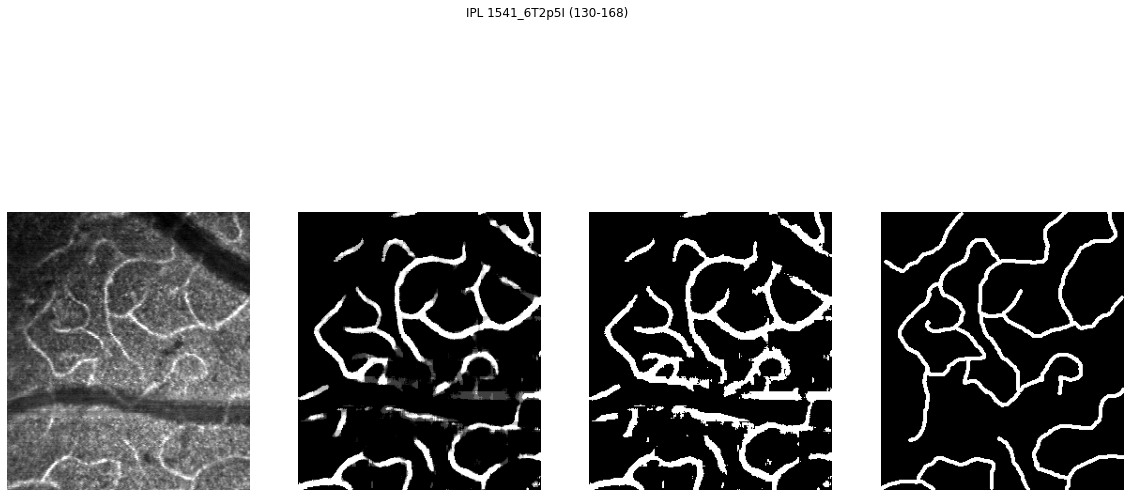

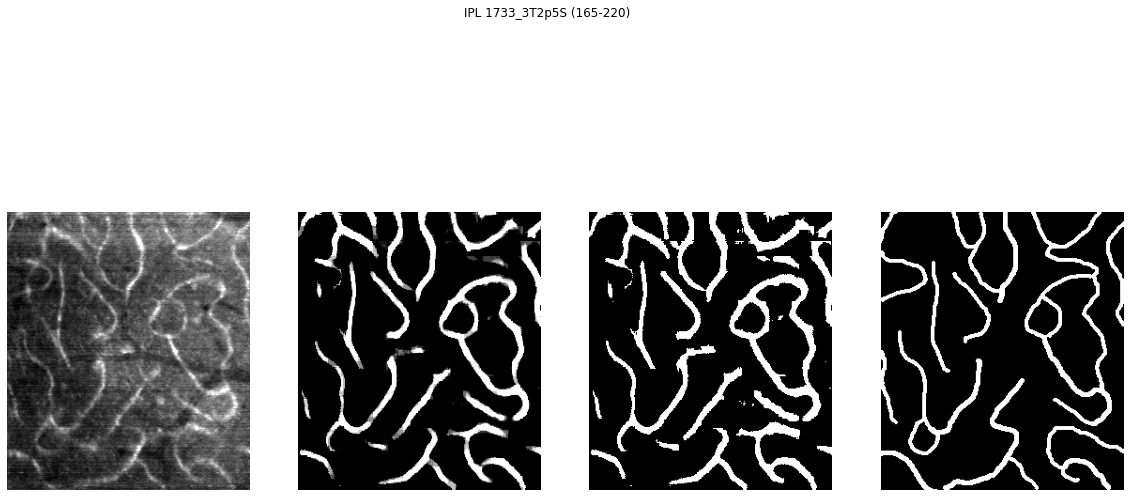

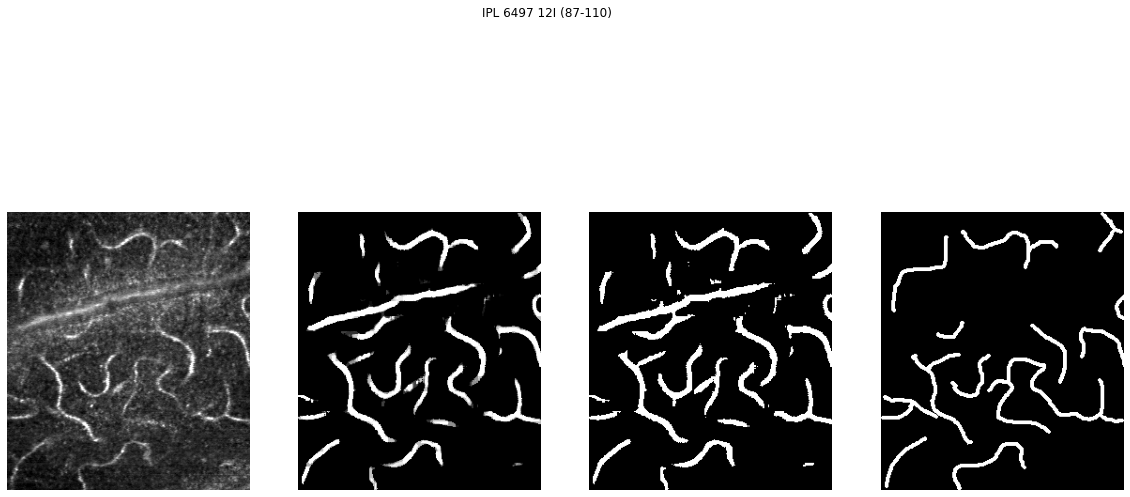

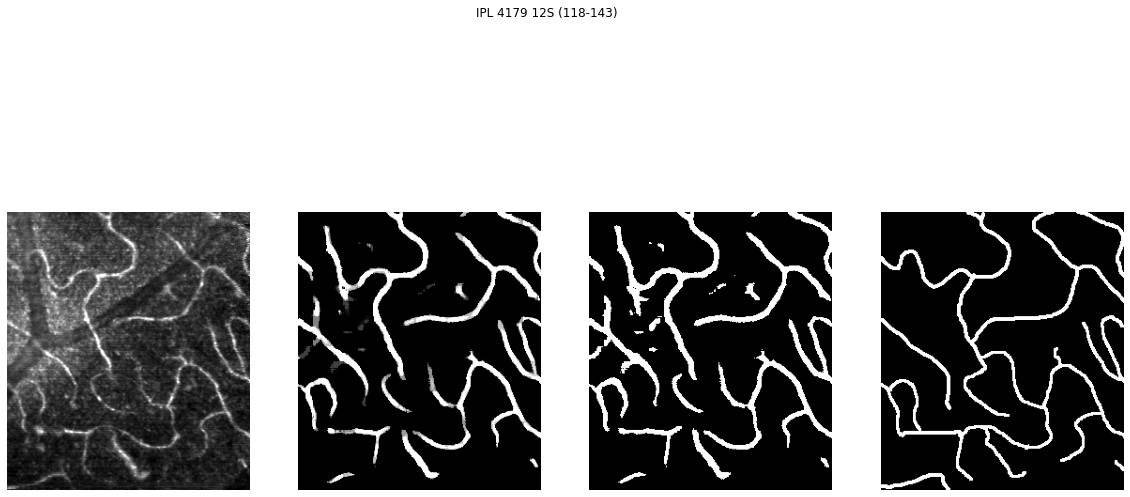

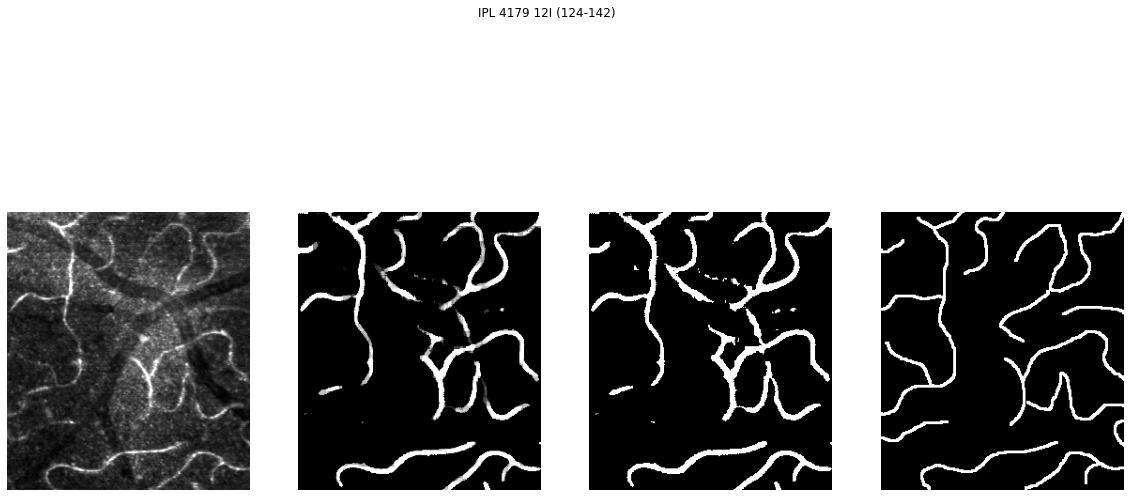

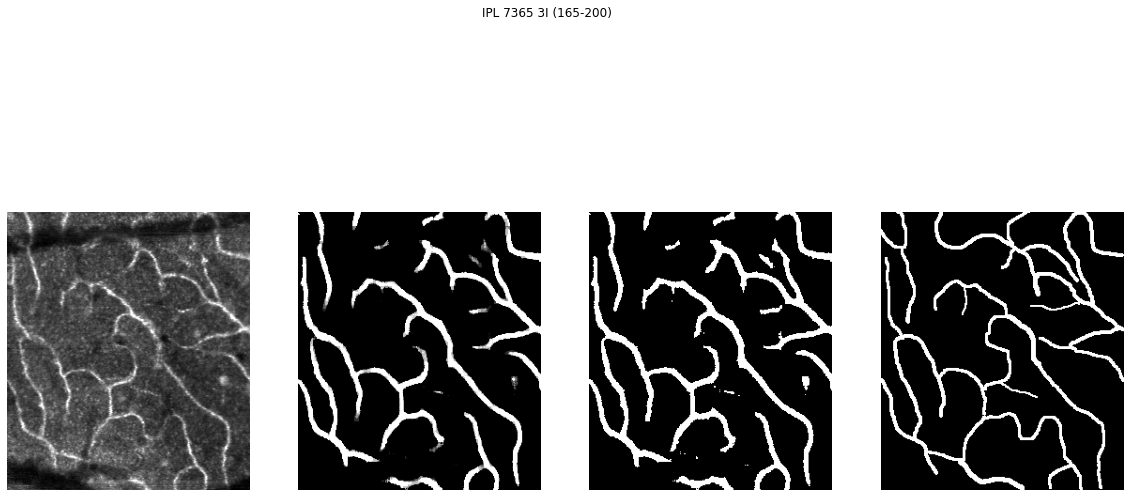

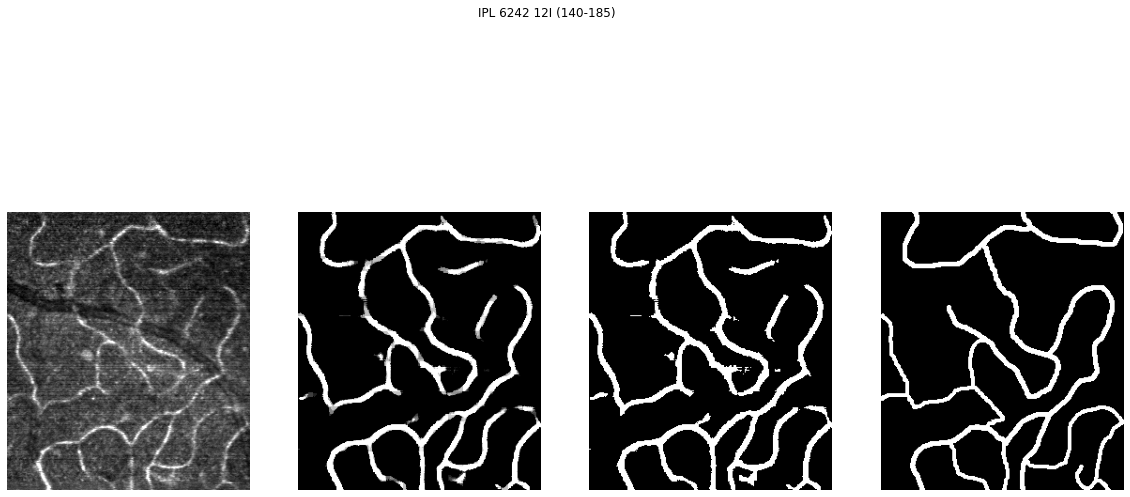

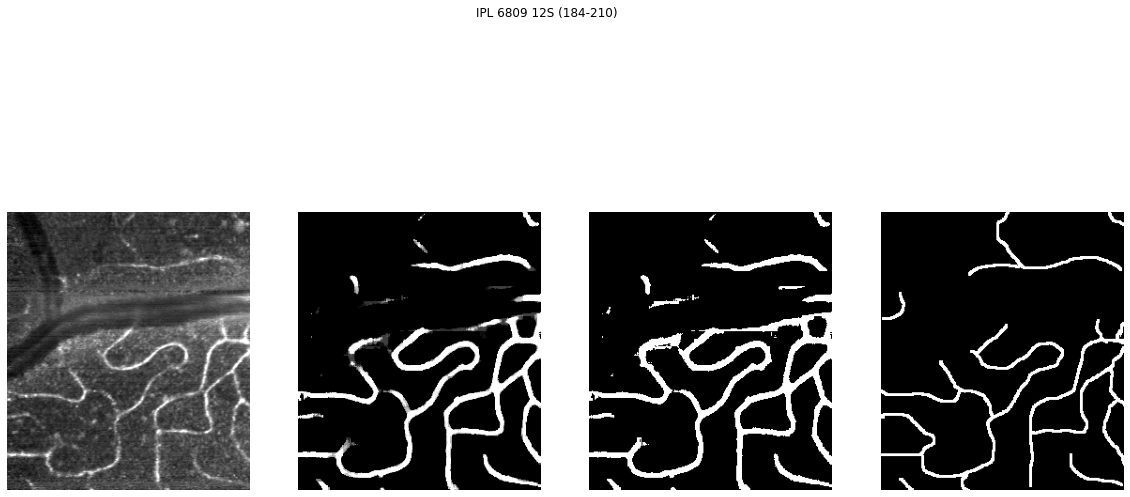

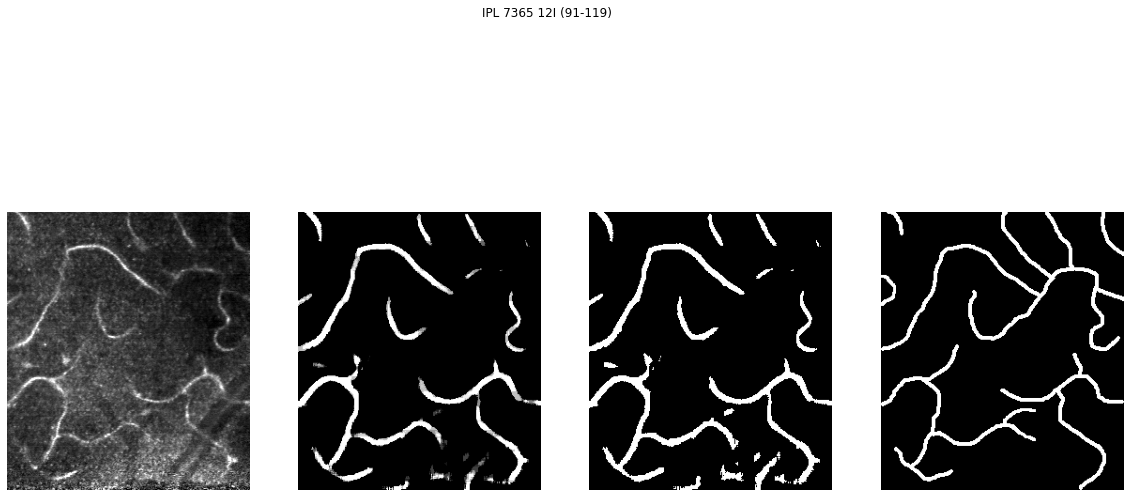

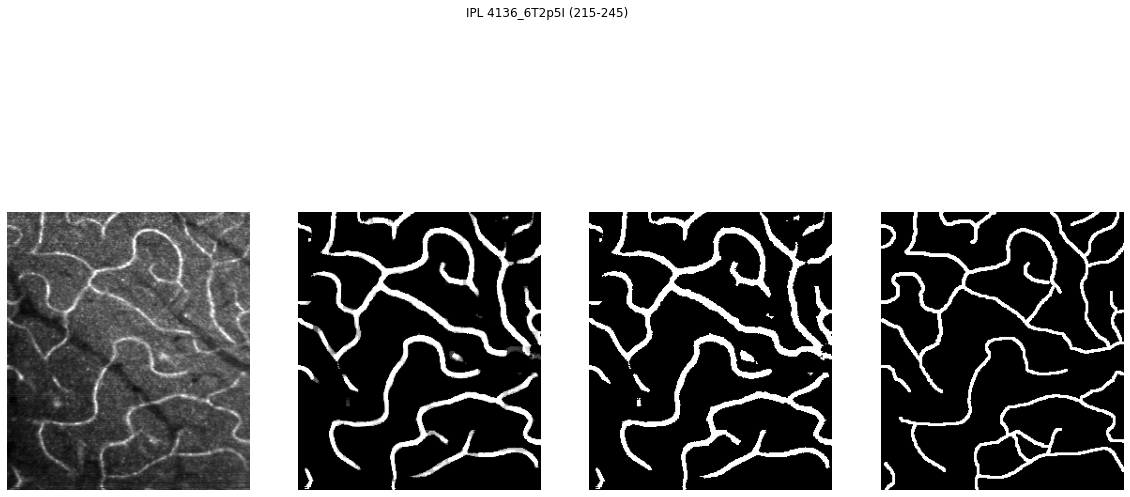

In [14]:
model.load_state_dict(torch.load('./models/last_model_2_all_5_5FINAL'))
model.eval()
input_dir = './processed_all'

pix = 256
total_dice = 0
total_precision = 0
total_recall = 0
total_acc = 0
total_auc = 0
count = 0

dice_out = []
prec_out = []
rec_out = []
acc_out = []
auc_out_ =[]
with torch.no_grad():
    for idx,sample in enumerate(test_loader):
        test_files = sample['filename']
        img_name = 'average.*'
        mask_name = '*binary*'
        filenames = sample['filename'] 
        
        
        for i in range(len(test_files)):
            filename = filenames[i]
            if filename == 'OPL 4136_3T2p5S (300-330)':
                starttime = timeit.default_timer()
                print("The start time is :",starttime)
                print("The time difference is :", timeit.default_timer() - starttime)
            img = io.imread(glob.glob(os.path.join(input_dir, filename, img_name))[0],as_gray=True)        
            mask = io.imread(glob.glob(os.path.join(input_dir, filename, mask_name))[0],as_gray=True)
            
            if mask.dtype == 'float64':
                mask = mask.astype('uint8')

            test = np.zeros(mask.shape)
            test[mask>np.round(np.max(mask)/2)] = 1
            mask = test.copy()

            raw_img = img.copy()
            img = imageJ_autocontrast(img)    
            f, axarr = plt.subplots(1,4,figsize=(20,10))
            output = full_image(model,transforms.ToTensor()(img).to(device))
            if filename == 'OPL 4136_3T2p5S (300-330)':
                print("The time difference is :", timeit.default_timer() - starttime)
            auc_out = get_auc(mask,output)
            total_auc += auc_out[0]

            bin_output = output > auc_out[1]/255 #greater than opt_thresh
            axarr[0].imshow(img,cmap='gray')
            axarr[1].imshow(output,cmap='gray')
            axarr[2].imshow(bin_output,cmap='gray')
            axarr[3].imshow(mask,cmap='gray')
            f.suptitle('{}'.format(filename))
            axarr[0].axis('off')
            axarr[1].axis('off')
            axarr[2].axis('off')
            axarr[3].axis('off')

            total_dice += dice_coef(transforms.ToTensor()(mask),transforms.ToTensor()(bin_output)).item()
            prec_rec_acc = othermetrics(mask,bin_output)
            total_precision += prec_rec_acc[0]
            total_recall += prec_rec_acc[1]
            total_acc += prec_rec_acc[2]
            
            dice_out.append(dice_coef(transforms.ToTensor()(mask),transforms.ToTensor()(bin_output)).item())
            prec_out.append(prec_rec_acc[0])
            rec_out.append(prec_rec_acc[1])
            acc_out.append(prec_rec_acc[2])
            auc_out_.append(auc_out[0])
            

            count += 1
     
print("dice: {}".format(total_dice/count))
print("prec: {}".format(total_precision/count))
print("recall: {}".format(total_recall/count))
print("accuracy: {}".format(total_acc/count))
print("AUC: {}".format(total_auc/count))
